In [1]:
from pathlib import Path
import json
from dataclasses import dataclass
from PIL import Image


@dataclass
class Frame:
    image: Image
    matrix: list[list[float]]


class Scene:
    def __init__(self, path: Path):
        with open(path / "transforms.json", "r") as f:
            transforms = json.load(f)

        self.shape = (transforms["w"], transforms["h"])
        self.angles = (transforms["camera_angle_x"], transforms["camera_angle_y"])

        self.frames: list[Frame] = []
        for frame in transforms["frames"]:
            image_path = path / frame["file_path"]
            if image_path.exists():
                self.frames.append(
                    Frame(
                        image=Image.open(image_path),
                        matrix=frame["transform_matrix"],
                    ),
                )


scene = Scene(Path("assets/fox"))

In [2]:
import torch as tch
from torch import nn
from torch.nn import functional as F
import numpy as np

In [3]:
dev = tch.device("cuda:0")

In [99]:
from typing import Callable


def raymarch(
    func: Callable[[tch.Tensor], tch.Tensor],
    init_rays: tch.Tensor,
    step_size: float,
    max_distance: float,
) -> tch.Tensor:
    """
    Args:
    + func(rays of shape (B, 6)) -> image of (B, 4)
    + init_rays of shape: (B, 6) where last dim contains: [px, py, pz, dx, dy, dz]
    + ...

    Returns image of shape (B, 4) where last dim contains: [r, g, b, opacity]
    """

    image_accum = tch.zeros((init_rays.shape[0], 4), device=init_rays.device)
    distance = 0.0
    while distance <= max_distance:
        init_pos, dir = init_rays[:, :3], init_rays[:, 3:]
        pos = init_pos + dir * distance
        rays = tch.cat([pos, dir], -1)

        image = func(rays)
        color, opacity = image[:, :3], image[:, 3:]
        old_color, old_opacity = image_accum[:, :3], image_accum[:, 3:]
        factor = (1.0 - old_opacity) * opacity
        new_color = old_color + factor * color
        new_opacity = old_opacity + factor
        image_accum = tch.cat([new_color, new_opacity], dim=-1)

        distance += step_size

    return image_accum


In [100]:
from nerfpg import grid


def pad_right(t: tch.Tensor, value: float, count: int = 1) -> tch.Tensor:
    return tch.cat(
        [t, tch.tensor(value, device=t.device).broadcast_to((*t.shape[:-1], count))],
        dim=-1,
    )


def rays_init(
    coords: tch.Tensor,
    transform: list[list[float]],
    angles: tuple[float, float],
) -> tch.Tensor:
    """
    coords shape: (B, 2) where coordinates are in a range from 0.0 to 1.0
    Returned tensor shape: (B, 6)
    """
    dev = coords.device
    bs = coords.shape[0]

    matrix = tch.tensor(transform, device=dev).transpose(0, 1)

    dxy = 2.0 * coords - 1.0
    dxy = dxy * (tch.tensor(angles, device=dev) / 2.0).tan()

    dir = pad_right(dxy, 1.0)
    dir = dir / dir.pow(2).sum(dim=-1, keepdim=True)  # normalize direction vectors
    dir = tch.matmul(pad_right(dir, 0.0), matrix)[:, :3]

    pos = matrix[3, :3].reshape((1, 3)).broadcast_to((bs, 3))
    return tch.cat([pos, dir], dim=-1)


def rays_grid(
    transform: list[list[float]],
    angles: tuple[float, float],
    shape: tuple[int, int],
    dev: tch.device,
) -> tch.Tensor:
    return rays_init(grid(shape, dev).flatten(0, 1), transform, angles).reshape(
        (*shape, -1)
    )


res = (256, 256)
distance = 4.0
transform = [
    [1.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, -distance],
    [0.0, 0.0, 0.0, 1.0],
]
rays = rays_grid(transform, (np.pi / 2, np.pi / 2), res, dev).flatten(0, 1)
rays

tensor([[ 0.0000,  0.0000, -4.0000, -0.3333, -0.3333,  0.3333],
        [ 0.0000,  0.0000, -4.0000, -0.3351, -0.3325,  0.3351],
        [ 0.0000,  0.0000, -4.0000, -0.3368, -0.3315,  0.3368],
        ...,
        [ 0.0000,  0.0000, -4.0000,  0.3368,  0.3315,  0.3368],
        [ 0.0000,  0.0000, -4.0000,  0.3351,  0.3325,  0.3351],
        [ 0.0000,  0.0000, -4.0000,  0.3333,  0.3333,  0.3333]],
       device='cuda:0')

In [ ]:
def gaussian_fog(rays: tch.Tensor) -> tch.Tensor:
    pos = rays[:, :3]
    density = pos.pow(2).sum(dim=-1, keepdim=True).exp().reciprocal()
    color = tch.tensor([0.0, 1.0, 0.0], device=rays.device).broadcast_to(
        (density.shape[0], 3)
    )
    return tch.cat([color, density], dim=-1)


gaussian_fog(rays)

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 1.1254e-07],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 1.1254e-07],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 1.1254e-07],
        ...,
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 1.1254e-07],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 1.1254e-07],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 1.1254e-07]], device='cuda:0')

In [7]:
image = raymarch(gaussian_fog, rays, 0.01, 2.0 * distance)
image

tensor([[0.0000, 0.0071, 0.0000, 0.0071],
        [0.0000, 0.0073, 0.0000, 0.0073],
        [0.0000, 0.0075, 0.0000, 0.0075],
        ...,
        [0.0000, 0.0075, 0.0000, 0.0075],
        [0.0000, 0.0073, 0.0000, 0.0073],
        [0.0000, 0.0071, 0.0000, 0.0071]], device='cuda:0')

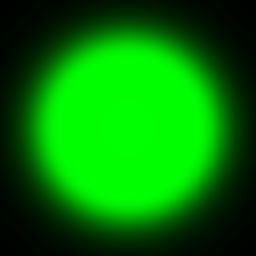

In [8]:
from nerfpg import tensor_to_image, image_to_tensor

tensor_to_image(image[:, :3].reshape(*res, 3).permute(2, 0, 1))

In [9]:
class CachedFrame:
    def __init__(self, frame: Frame, dev: tch.device):
        self.image = image_to_tensor(frame.image, dev)
        self.matrix = frame.matrix  # TODO: Cache matrix

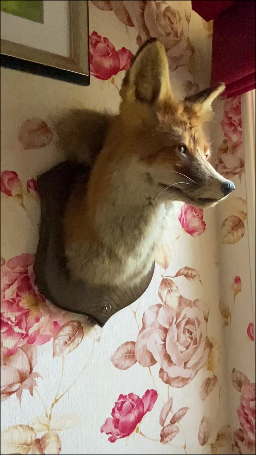

In [10]:
def sample_image(img: tch.Tensor, coords: tch.Tensor) -> tch.Tensor:
    return (
        F.grid_sample(
            img.unsqueeze(0),
            (coords * 2.0 - 1.0).unsqueeze(0).unsqueeze(0),
            align_corners=False,
        )
        .squeeze(0)
        .squeeze(1)
    )


frames = [CachedFrame(frame, dev) for frame in scene.frames]

shape = (256, int(256 * (scene.shape[1] / scene.shape[0])))
tensor_to_image(
    sample_image(
        frames[0].image,
        grid(shape, dev).transpose(0, 1).flatten(0, 1),
    ).reshape((-1, shape[1], shape[0]))
)

In [101]:
def sample_model(
    model: nn.Module,
    coords: tch.Tensor,
    scene: Scene,
    transform: list[list[float]],
    step_size: float,
    max_distance: float,
) -> tch.Tensor:
    rays = rays_init(coords, transform, scene.angles)
    return raymarch(lambda xs: model.forward(xs), rays, step_size, max_distance)[:, :3]


def infer(
    model: nn.Module,
    res: tuple[int, int],
    dev: tch.device,
    scene: Scene,
    transform: list[list[float]],
    step_size: float,
    max_distance: float,
) -> Image:
    model.train(False)
    rays = rays_grid(transform, scene.angles, res, dev).transpose(0, 1).flatten(0, 1)
    ys = raymarch(lambda xs: model.forward(xs), rays, step_size, max_distance)
    out = ys.transpose(0, 1).reshape((-1, *res))
    return tensor_to_image(out)

In [102]:
step_size = 0.1
max_distance = 10.0

In [103]:
from nerfpg import encode_coord


def encode_rays(rays: tch.Tensor, n_modes: int, factor: float) -> tch.Tensor:
    pos, dir = rays[:, :3], rays[:, 3:]
    return tch.cat([dir, encode_coord(pos, n_modes, factor)], dim=-1)

In [104]:
from nerfpg import Lambda

dim = 256
n_modes = 64
model = nn.Sequential(
    Lambda(lambda x: encode_rays(x, n_modes, 1.0 / max_distance)),
    nn.Linear(3 + 3 * n_modes, dim),
    nn.ReLU(),
    nn.Linear(dim, dim),
    nn.ReLU(),
    nn.Linear(dim, 4),
    nn.Sigmoid(),
)
model = model.to(dev)

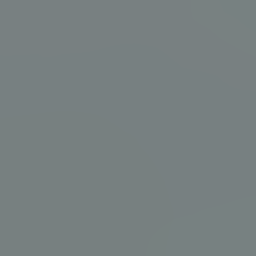

In [105]:
infer(
    model,
    (256, 256),
    dev,
    scene,
    scene.frames[0].matrix,
    step_size,
    max_distance,
)

In [106]:
batch_size = 16 * 1024
optim = tch.optim.AdamW(model.parameters(), lr=1e-3)

'9: 0.043327704071998596'

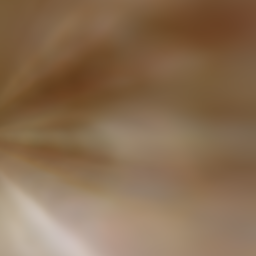

In [110]:
from IPython.display import display

display_loss = display(display_id=True)
display_sample = display(display_id=True)

for epoch in range(10):
    model.train(True)

    total_loss = 0.0
    for frame in frames: # [:1] * len(frames):
        model.zero_grad()

        xs = tch.rand((batch_size, 2), device=dev)
        ys = sample_model(
            model,
            xs,
            scene,
            frame.matrix,
            step_size,
            max_distance,
        ).transpose(0, 1)

        ref = sample_image(frame.image, xs)
        loss = F.mse_loss(ys, ref)
        total_loss += loss.numpy(force=True)

        loss.backward()
        optim.step()

    total_loss /= len(frames)
    display_loss.update(f"{epoch}: {total_loss}")

    display_sample.update(
        infer(model, (256, 256), dev, scene, frames[0].matrix, step_size, max_distance)
    )